# PJM data processing 3

The load data are obtained from PJM.

'inst_load.csv' stores actual 5min load, 'very_short_load_frcst.csv' stores forecast 5min load, 'are_control_error.csv' stores the ACE every 15s.

All data are in MW.

Synthetic demand data from actual PJM datasets, the output is 'd_syn3.csv'.

Output = Load

Output contains 3600s of hour 10 and hour 18 in 3600 rows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

In [2]:
dir_path = os.path.abspath('..')
data_path = '/data/'
load_inst = pd.read_csv(dir_path+data_path+"inst_load.csv")
load_frct = pd.read_csv(dir_path+data_path+"very_short_load_frcst.csv")
ace0 = pd.read_csv(dir_path+data_path+"area_control_error.csv")

In [3]:
ace = ace0[['datetime_beginning_utc', 'ace_mw']].copy()
ace.columns = ['utc_time', 'ace']
ace = ace[ace["utc_time"].str[:3] == '2/3'].copy()

ace["utc_time"] = pd.to_datetime(ace["utc_time"]).dt.strftime('%H:%M:%S')
# ace["utc_time"] = ace["utc_time"].dt.strftime('%H:%M:%S')

ace.sort_values(by="utc_time", inplace=True)
ace.reset_index(inplace=True, drop=True)

In [4]:
d_inst = load_inst[['datetime_beginning_utc', 'instantaneous_load']].copy()
d_frst0 = load_frct[['forecast_datetime_beginning_utc', 'forecast_load_mw']].copy()

d_inst.columns = ["utc_time", "d_inst"]
d_frst0.columns = ["utc_time", "d_frst"]

d_frst = d_frst0.groupby(by="utc_time", as_index=True, dropna=False).mean()
d_frst.reset_index(level=0, inplace=True)

d_data = pd.merge(d_inst, d_frst, on="utc_time", how="left")
d_data = d_data[d_data["utc_time"].str[:3] == '2/3'].copy()

d_data["utc_time"] = pd.to_datetime(d_data["utc_time"])
d_data["utc_time"] = d_data["utc_time"].dt.strftime('%H:%M:%S')

d_data.sort_values(by="utc_time", inplace=True)
d_data.reset_index(inplace=True, drop=True)

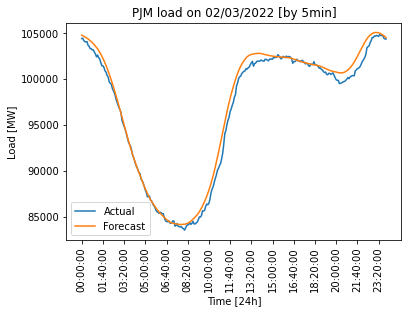

In [5]:
data_in = d_data
x = range(data_in.shape[0])
y1 = data_in["d_inst"]
y2 = data_in["d_frst"]

xt_loc = np.arange(0, data_in.shape[0], step=20)
xt_txt = data_in["utc_time"].iloc[xt_loc]

plt.plot(x, y1, label="Actual")
plt.plot(x, y2, label="Forecast")
plt.xticks(xt_loc, xt_txt, rotation=90)
plt.title("PJM load on 02/03/2022 [by 5min]")
plt.legend()
plt.xlabel("Time [24h]")
plt.ylabel("Load [MW]")
plt.show()

(60, 3)


<AxesSubplot:>

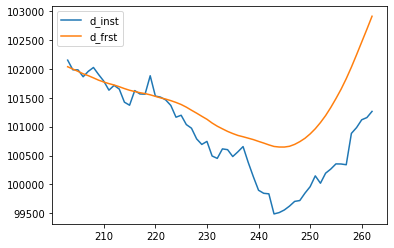

In [6]:
# 12 poitns for 1 hour, 60 points for 5 hour
# [17pm-22pm, 203]
x1 = 203
d_data_plt = d_data[x1:x1+60]
print(d_data_plt.shape)
d_data_plt.plot()

   utc_time     ace
0  00:00:05  217.49
1  00:00:20  166.63
2  00:00:35  122.01


Text(0, 0.5, 'ACE [MW]')

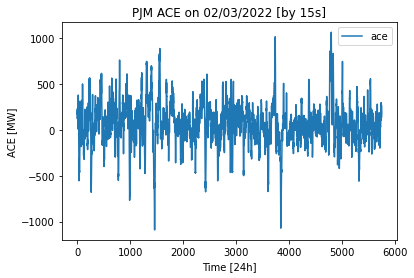

In [7]:
ax_ace = ace.plot()

print(ace.iloc[0:3])

xt_loc = np.arange(0, ace.shape[0], step=250)
xt_txt = ace["utc_time"].iloc[xt_loc]

# ax_ace.set_xticks(xt_loc, xt_txt)
ax_ace.set_title("PJM ACE on 02/03/2022 [by 15s]")
ax_ace.set_xlabel("Time [24h]")
ax_ace.set_ylabel("ACE [MW]")

In [8]:
# Interpolate instant laod
# select a range and then interpolate it to 3600s

x1 = 17*240
ace_sub = ace[x1:x1+240+1].copy()
ace_sub['time'] = list(range(0, 3610, 15))

ace_f = interp1d(ace_sub['time'], ace_sub['ace'])
ace_y = ace_f(np.array(range(3600)))

In [9]:
# Interpolate load
# select a range and then interpolate it to 3600s

# 12 poitns for 1 hour, 60 points for 5 hour
# [17pm-22pm, 203]

x1 = 203
d_data_sub = d_data[x1:x1+60+1].copy()
print(d_data_sub.shape)
d_data_sub['time'] = list(range(0, 3610, 60))

d_data_f = interp1d(d_data_sub['time'], d_data_sub['d_inst'])
d_data_y = d_data_f(np.array(range(3600)))

(61, 3)


In [10]:
# Synthesize load
d_syn = pd.DataFrame()
d_syn['time'] = range(3600)
d_syn['h10'] = d_data_y

Text(0.5, 0.07, 'Time[s]')

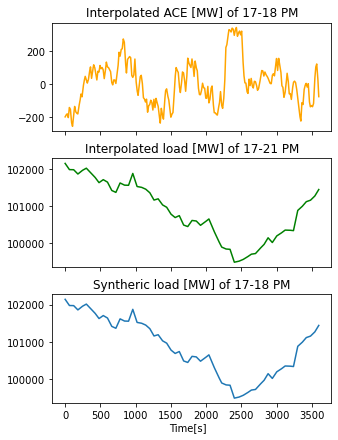

In [11]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(5,7))

ydata = [ace_y, d_data_y, d_syn['h10']]
color = ['orange', 'green', '']
title = ["Interpolated ACE [MW] of 17-18 PM", "Interpolated load [MW] of 17-21 PM", "Syntheric load [MW] of 17-18 PM"]

for idx,ax in enumerate(axs):
    ax.plot(d_syn['time'], ydata[idx], color[idx])
    ax.set_title(title[idx])

fig.subplots_adjust(hspace=0.25)
fig.text(0.5, 0.07, 'Time[s]', ha='center')

In [12]:
d_syn

,time,h10
0,0,102149.000000
1,1,102146.213333
2,2,102143.426667
3,3,102140.640000
4,4,102137.853333
...,...,...
3595,3595,101434.333333
3596,3596,101437.446667
3597,3597,101440.560000
3598,3598,101443.673333


In [13]:
d_syn.to_csv(dir_path+'/case/d_syn3.csv', index=False)